# 2020.06.03_multi_return_online_model
-----

* updateing online rnn to support multiple disjoint return

### Version Info
* madmax: `093d93a`
* research: `7481ed3`

---
## History

#### 2020.06.01_online_pca
* Reimplemeting statfacs using online pca


#### `2020.05.28_baselines.ipynb`
-----
* Baselines for the technical features data 
* testing gradeitn descent vs mbprox
* testing fast vs slow hl_2 in onlineRnn

#### `2020.05.27 statfacs grid`
* Statfacs initialized with the loadings from the previous minibatch
* Building an online model using statfacs as both features and residualization target
* Comprehensive grid of statfacs


##### `etf_technical_2020.05.27 (more statfacs)`
* Statfacs initialized with the loadings from the previous minibatch
* Building an online model using statfacs as both features and residualization target


##### `etf_technical_2020.05.19 (stat factors).ipynb`
* Computed statistical factors using
    + random initialization  in minibatches
    + iteratively added new statfacs - maintaining orthogonality to previous statfacs
    + different kappas and window lenghts
* Established baselines for the model withotu statfacs
* Ran some basic regressions with statfacs (not residualization)



##### `etf_technical_2020.05.17 (features profiling).ipynb`. 
* adding ta-lib like features for 500 ETFs. Feature profiled, online learning model

##### `etf_technical_2020.05.13`
* I had gotten omega weighting done (seems to add a little bit but not much)


In [ ]:
50000 * 525 * 130

In [1]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler
%load_ext line_profiler

from pylab import *
from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()
plt.style.use('seaborn-whitegrid')

###################################################################
# Interactive configuration
# When running a config grid this will throw a FrozenException
# and the grid Config will be used
###################################################################
try:
    mx.Config.name = 'etf_technical/multi_return_online_model/'
    mx.Config.mode = 'interactive'
    mx.Config.hps = mx.HPSet()
    mx.Config.code = '2020.06.03_multi_return_online_model.ipynb'
    disp('Running interactive configuration ', h=2)
except mx.Config.FrozenException:
    if mx.Config.mode != 'grid':
        raise RuntimeError('An unexpected configruation encountered')
    disp('Running a grid configuration ', h=2)

device = 'cuda'
dtype = tr.float32
mx.Config.start()
hps = mx.Config.hps

# to run run a grid of hyperparameters ...
####################################
# # hyperparameters
# mx.Config.hps = fr.HPSet(
# )
# mx.Config.code = ''
# # configs = []
# # for obs_weight in ['no_weight', 'dollar_weight', 'log_weight']:
# #     cfg = fr.Config.clone()
# #     cf
# #     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
# #     cfg.freeze()
# #     display_html( cfg )
# #     configs.append( cfg )
# # notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - weight_grid_results.ipynb', n_jobs=None )

Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.


<IPython.core.display.Javascript object>

## interactive global hyperparameters

In [2]:
# global  configruation
#######
if mx.Config.mode == 'grid':
    raise mx.Config.FrozenException( 'running grid configruation - skipping')

hps.start = '20070101'
hps.end='20200501'
hps.INTS_PER_DAY = 13

hps.universe = mx.HPSet(
    start = '20100101',
    end='20200401',
    min_count=2000,
    min_dollar_vol=1e5
)


hps.feature_set = mx.HPSet(
    unadj_prices=[
        'open_unadj_30min', 'high_unadj_30min', 'low_unadj_30min', 'close_unadj_30min', 'mid_unadj_30min',
        'log_open_unadj_30min', 'log_close_unadj_30min',
    ],
    adj_prices=[
        'open_adj_30min', 'high_adj_30min', 'low_adj_30min', 'close_adj_30min',
        'mid_adj_30min', 'mid_adj_0D.12h.vwap', 'mid_adj_2D.12h.vwap', 'mid_adj_5D.vwap',
        'open_adj_0D.12h', 'high_adj_0D.12h', 'low_adj_0D.12h',
        'open_adj_2D.12h', 'high_adj_2D.12h', 'low_adj_2D.12h',
        'open_adj_5D', 'high_adj_5D', 'low_adj_5D',
    ],
    rel_prices=[
        'rel_price_260', 'rel_price_780', 'rel_price_3276',
    ],
    volumes=[
        'volume_unadj_30min', 'dollar_volume_unadj_30min', 'avg_dollar_volume',
    ],
    log_volumes=[
        'log10_dollar_volume_30min', 'log10_dollar_volume_30min_resid',
    ],
    rel_volume=[
        'rel_dollar_volume_260', 'rel_dollar_volume_780',
        'rel_dollar_volume_3276',
    ],
    calendar=[
        'timeofday', 'cos1_timeofday', 'cos2_timeofday', 'cos4_timeofday',
        'dayofweek', 'cos1_dayofweek', 'cos2_dayofweek',
        'weekofmonth', 'cos1_weekofmonth', 'cos2_weekofmonth',
        'monthofquarter', 'cos1_monthofquarter', 'cos2_monthofquarter',
        'quarterofyear', 'cos1_quarterofyear', 'cos2_quarterofyear',
    ],
    lagging=[
        'lagrtn_adj_30min', 'lagrtn_adj_1hr', 'lagrtn_adj_1day',
        'lagrtn_adj_30min_resid',
    ],
    mkt=[
        'mkt_lagrtn_30min',
        'mkt_lagrtn_30min_260.rw_sd', 'mkt_lagrtn_30min_780.rw_sd', 'mkt_lagrtn_30min_3276.rw_sd',
    ],
    vol=[
        'lagrtn_adj_30min_260.rw_sd', 'lagrtn_adj_30min_780.rw_sd', 'lagrtn_adj_30min_3276.rw_sd',
        'lagrtn_adj_30min_resid_260.rw_sd', 'lagrtn_adj_30min_resid_780.rw_sd', 'lagrtn_adj_30min_resid_3276.rw_sd',
    ],
    zscores=[
        'lagrtn_adj_30min_260.rw_zscore', 'lagrtn_adj_30min_780.rw_zscore', 'lagrtn_adj_30min_3276.rw_zscore',
        'lagrtn_adj_30min_resid_260.rw_zscore', 'lagrtn_adj_30min_resid_780.rw_zscore',
        'lagrtn_adj_30min_resid_3276.rw_zscore',
    ],
    betas=[
        'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min_2340.ew_beta',
        'lagrtn_adj_30min_3276.ew_beta', 'lagrtn_adj_30min_6500.ew_beta',
    ],
    afacs=[ 'bw_afac_30min', 'fw_afac_30min' ],
    technical=[
        'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
        'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
        'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
        'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
        'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
    ],    
)

hps.leading_rtns = [
    'leadrtn_adj_30min', 'leadrtn_adj_1hr', 'leadrtn_adj_1day',
    'mkt_leadrtn_30min', 'mkt_leadrtn_1day',
    'leadrtn_adj_30min_disjoint.1', 'leadrtn_adj_30min_disjoint.2', 'leadrtn_adj_30min_disjoint.3',
]

hps.weights = ['valid_30min', 'weight', ]

    
hps.online = mx.HPSet(
    start=hps.start, #'20150101'
    end=hps.end, #  '20080101', # 
    batch_size=1000,
    features=sorted( set(
        []
        + ['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid', ]
        + hps.feature_set.lagging
        + hps.feature_set.vol
        + hps.feature_set.log_volumes
        # + hps.feature_set.calendar
        + hps.feature_set.mkt
        + hps.feature_set.betas
        # + hps.feature_set.technical
        # + hps.feature_set.afacs
    ) ),
    symbol=None,
    targets='leadrtn_adj_30min',
    target_shift=None,  # advance the targetc
    lookahead=2,
    ridge=1e-5,
    hl_1=None,
    hl_2=None,
    lr=500,
    kappa=2,  # util penalty
    rnn_tv=None,  # {1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13,
    # orthogonalize out short term mean reversion
    ortho_features=['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas,
    weight='valid_30min',
    algo='mbprox',
    # stuff related to sid weighting
    use_omega='P',
    omega_lr=10,
    omega_ridge=0,
    omega_shift=0.1,
    # stuff related to pre and post processing
    winsorize_target=False,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13 * 5, 13 * 20, 13 * 40], ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

<IPython.core.display.Javascript object>


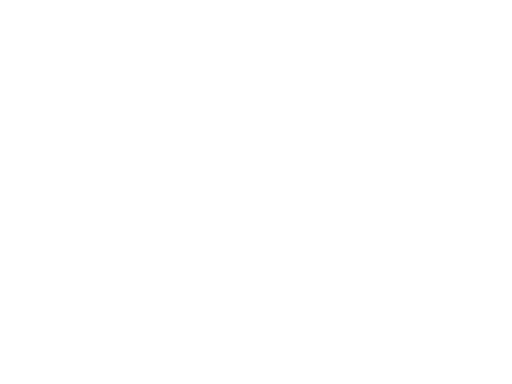

In [3]:
# identify the universe of ETFS
#############################################################
%nbagg
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )

etf_stats = etfd.compute_etf_stats()
etf_stats = etf_stats[etf_stats.vendor=='kibot']
orig_len = len( etf_stats )
# drop etfs without enough history
etf_stats = etf_stats[(etf_stats['start'] <= hps.universe.start ) 
                      & (etf_stats['end'] > hps.universe.end ) 
                      & (etf_stats['n'] >= hps.universe.min_count)
                      & (etf_stats['daily_dollar_volume_adj'] >= hps.universe.min_dollar_vol ) ]

disp( 'after filtering', len( etf_stats ), 'symbols out of original ' ,orig_len )

etf_stats = (etf_stats
             .merge( etfd.all_etfs, how='left', left_on='symbol', right_on='Symbol' )
             .drop( columns=['Symbol', 'ETP Name', 'Leveraged / Inverse' ])
             .rename( columns={'Asset Class':'asset_class', 'Description':'name'} )
             .fillna( 'Not Specified')             
             .set_index('symbol')
            )
disp( etf_stats.groupby('asset_class').name.count() )

ax = subplot( 2,2, 1 )
etf_stats.n.hist(ax=ax, bins=50)
ax.set_title( 'counts')

ax = subplot( 2,2, 2 )
etf_stats.start.hist(ax=ax, bins=50)
ax.set_title( 'start dates')

ax = subplot( 2,2, 3 )
etf_stats.daily_dollar_volume_adj.log10().hist(ax=ax, bins=50)
ax.set_title( 'log10 daily dollar volume')

# this is the universe we will work with. 
# HERO has a massive returns spike in 2015.11.09 - which throws off residualization quite a bit.
hps.universe.symbols = sorted( etf_stats.index.values )


In [4]:
# build up the data and features
#############################################
%inline
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )
from research.etf_technical import etf_technical_20200517 as etfrc; reload( etfrc )

# fetch the data as a dataarray
builder = etfd.BuildDataWithAfacs( symbols=hps.universe.symbols, mkt_only=True, start=hps.start ,).set( memoize=True )
builder.data = None
disp( 'builder BuildDataWithAfacs_7f79ef4bf  expected got', builder.hash() )
da = builder(  )
df = builder.output_meta

# hyperparams related to computing returns and residuals
hps.returns_hps = mx.HPSet(    
    price_windows=[ 24*1, 24*5, 24*10],
    beta_halflifes=[13 * 90, 13 * 180, 13 * 252, 13*500],
    dollar_volume_window=13*180,
    ema_halflifes=[20 * 13, 60 * 13, 252 * 13],
    resid_halflife=13,
    
)
# compute log-returns, log-dollar-volume, betas, residual returns and clean up the data
rtn_computer = etfrc.compute_returns_and_betas( 
    start=hps.start, end=None,     
    dollar_volume_window=hps.returns_hps.dollar_volume_window, 
    price_windows = hps.returns_hps.price_windows,
    beta_halflifes=hps.returns_hps.beta_halflifes, 
    resid_halflife=None,    
) 
rtn_computer.data = builder
disp( 'expected compute_returns_and_betas_9280a30dd got', rtn_computer.hash(), h=4, color='teal' )

# add relative price and relative volume features
rel_price_and_vols = etfrc.add_relative_price_and_volumes( emas=hps.returns_hps.ema_halflifes )
rel_price_and_vols.data = rtn_computer
disp( 'expected add_relative_price_and_volumes_a65da371a got', rel_price_and_vols.hash(), h=4, color='teal' )

# add volatility and calendar features
add_vols = etfrc.add_volatilities( emas=hps.returns_hps.ema_halflifes )
add_vols.data = rel_price_and_vols
disp( 'expected add_volatilities_77ca914f0 got', add_vols.hash(), h=4, color='teal' )

# add disjoint returns
disjoint_returns= etfrc.add_dijoint_returns( lags=(1, 2, 3) )
disjoint_returns.data = add_vols
disjoint_returns.features = 'leadrtn_adj_30min'
disp( 'expected add_dijoint_returns_ed1f196d1 got', disjoint_returns.hash(), h=4, color='teal' )
da = disjoint_returns(   )

In [5]:
# Various profiling utilities
##############################################################################
%inline
@mx.operatorize( memoize=True, produces_features=False )
def FeatureCorrelations( data, features, start, frac=0.5 ):
    '''computer feature set correlations'''
    data = data.loc[start:, :, features]
    if frac:
        ix = pd.Series( range( len( data ) ) ).sample( frac=frac, random_state=1 )
        data = data[ix.values]
    return data.corr_mx()

def process_one_feature_set( data, fs_features=None, leading=hps.leading_rtns ):
    '''profile one feature set '''
    with mx.timer( 'computing feautre coorelations' ):
        fc = FeatureCorrelations( start=None )
        fc.data = data
        fc.features = fs_features + leading
        corr_df = fc()
    with mx.timer( 'running profile' ):
        #  -- profile the features
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1day',],
            exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'mkt_lagrtn_30min'],
            transforms=None, weight='weight', winsorize=0.05, xs=None, start=None,
            lags=[1, 3, 5], autocorr=[1, 2, 13]
        ).set( verbose=False, memoize=True )
        profiler.data = data
        profiler.features = fs_features 
        profiler.run()
    return corr_df, profiler



# for fs in ['statfac', 'technical', 'afacs', 'betas' ]: #+ list( hps.feature_set.keys() ):    
#     fs_features = getattr( hps.feature_set, fs )
#     disp( 'processing ', fs_features, h=2 )
#     corr_df, profiler = process_one_feature_set( fs_features=fs_features ) 
#     mx.disp( corr_df.loc[fs_features], corr=True )    
#     profiler.display()     

# Baselines
----

# baseline 1 - with single returns

In [10]:
runner.output_features

['leadrtn_adj_30min_hat',
 'leadrtn_adj_30min_hat_xs_winsorize',
 'leadrtn_adj_30min_hat_xs_zscore',
 'leadrtn_adj_30min_hat_xs_winsorize_xs_zscore']

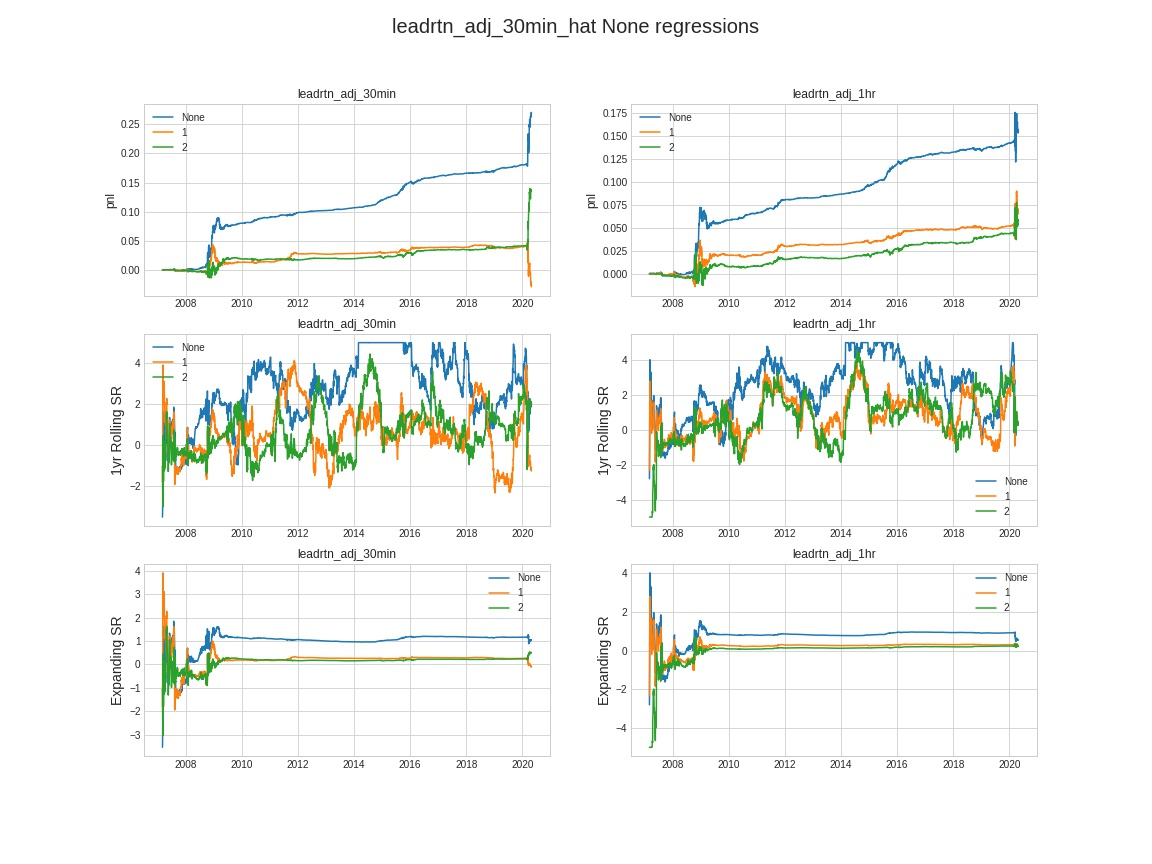

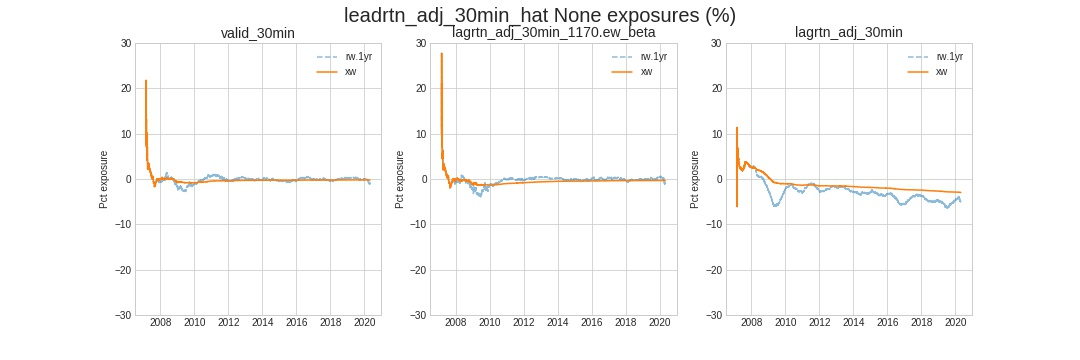

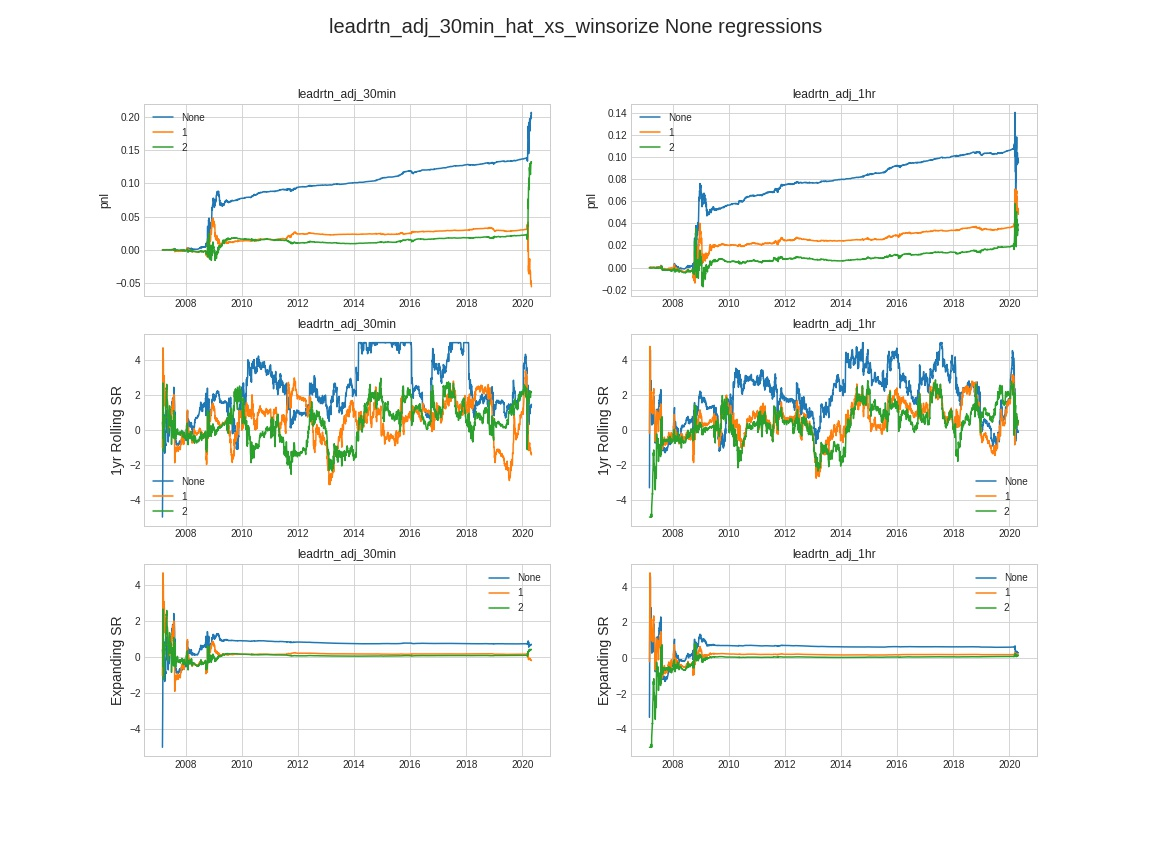

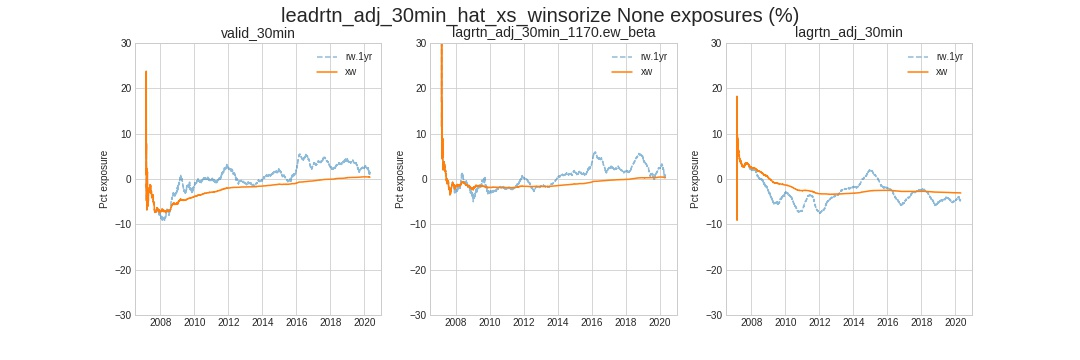

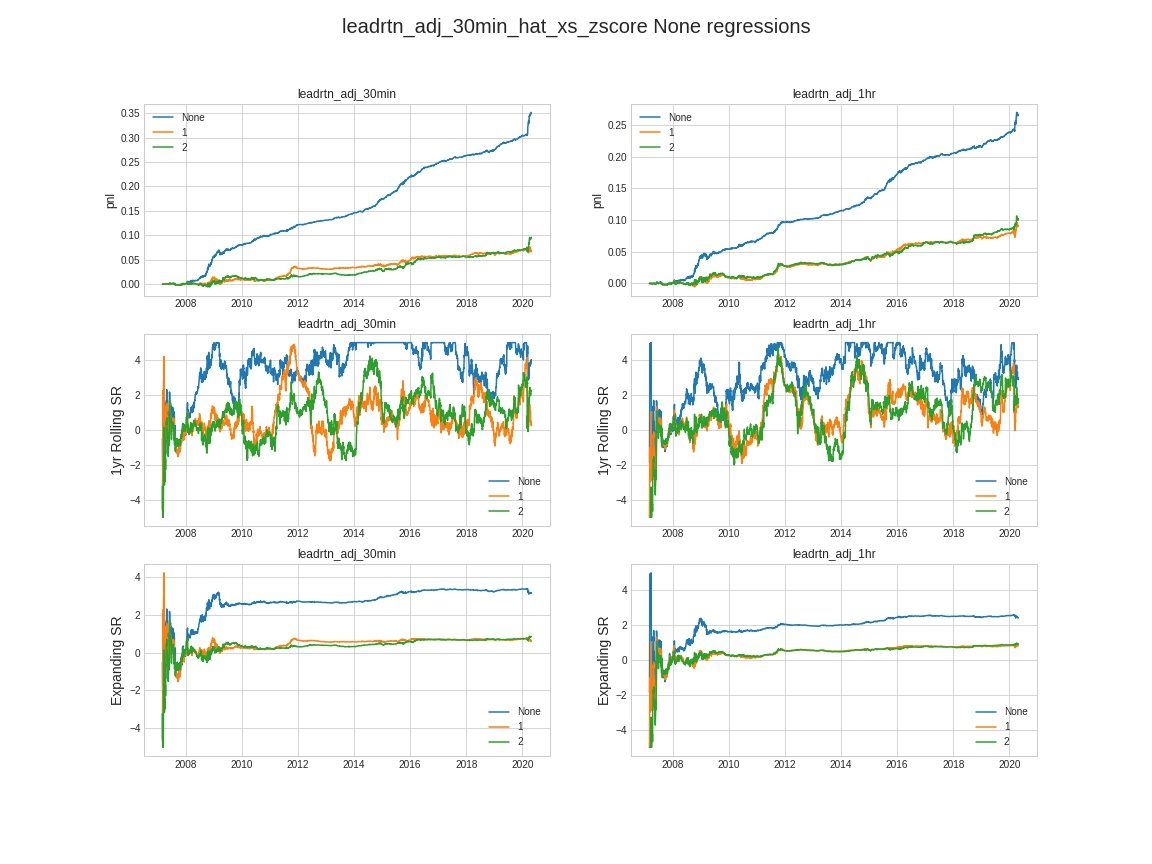

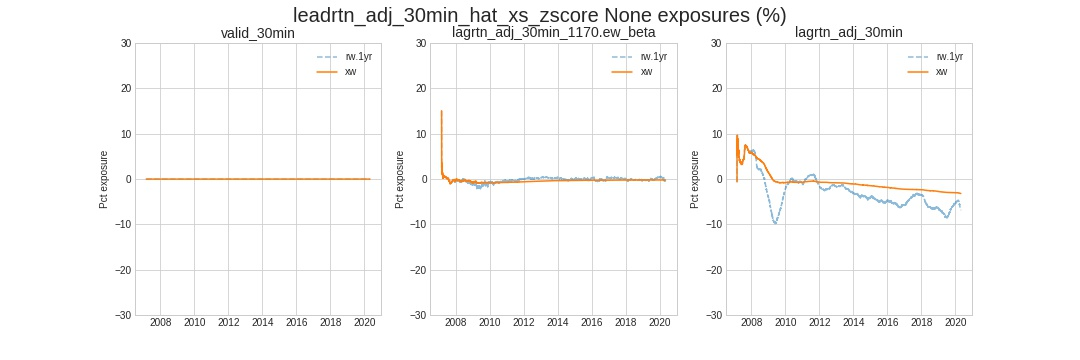

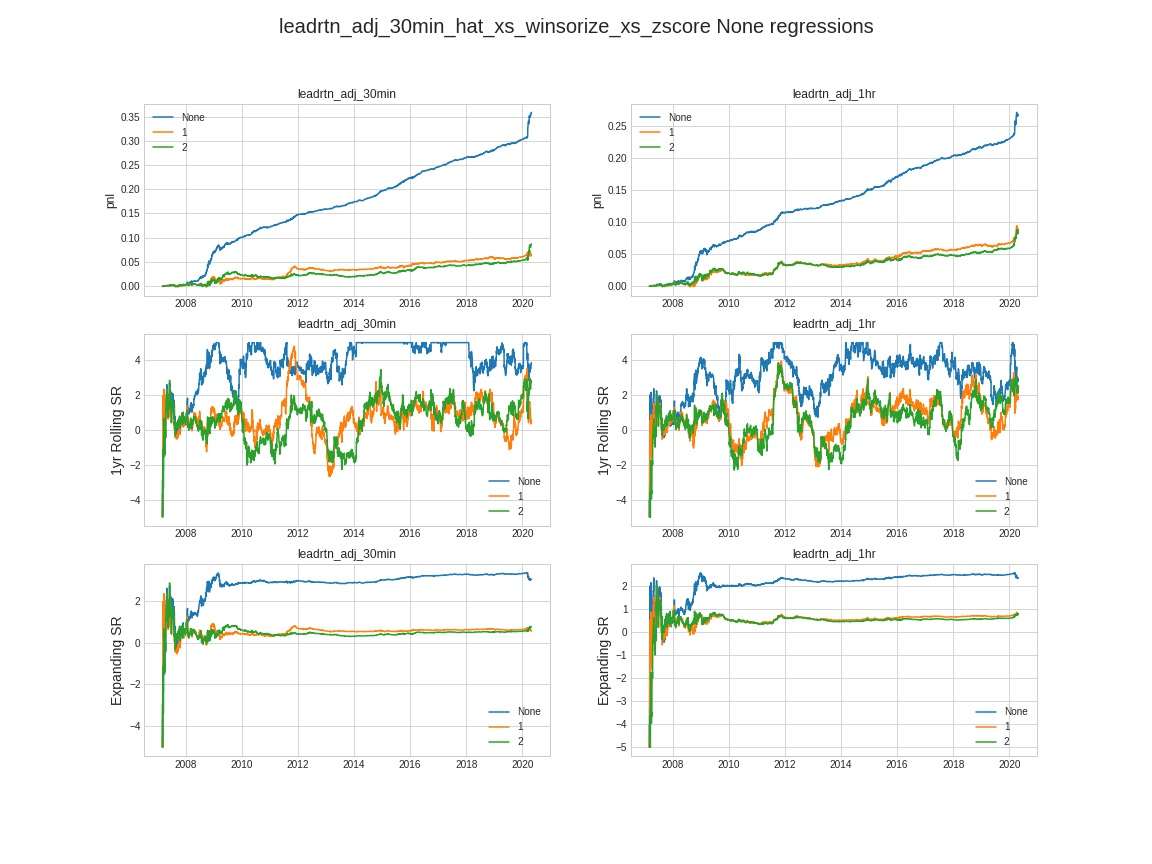

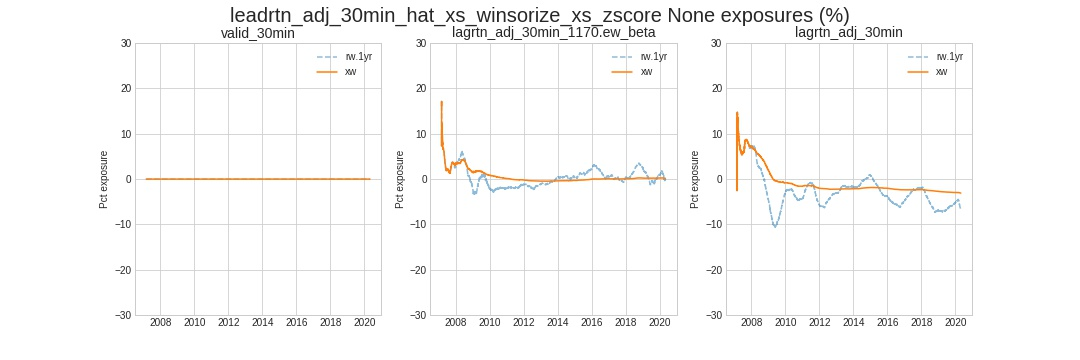

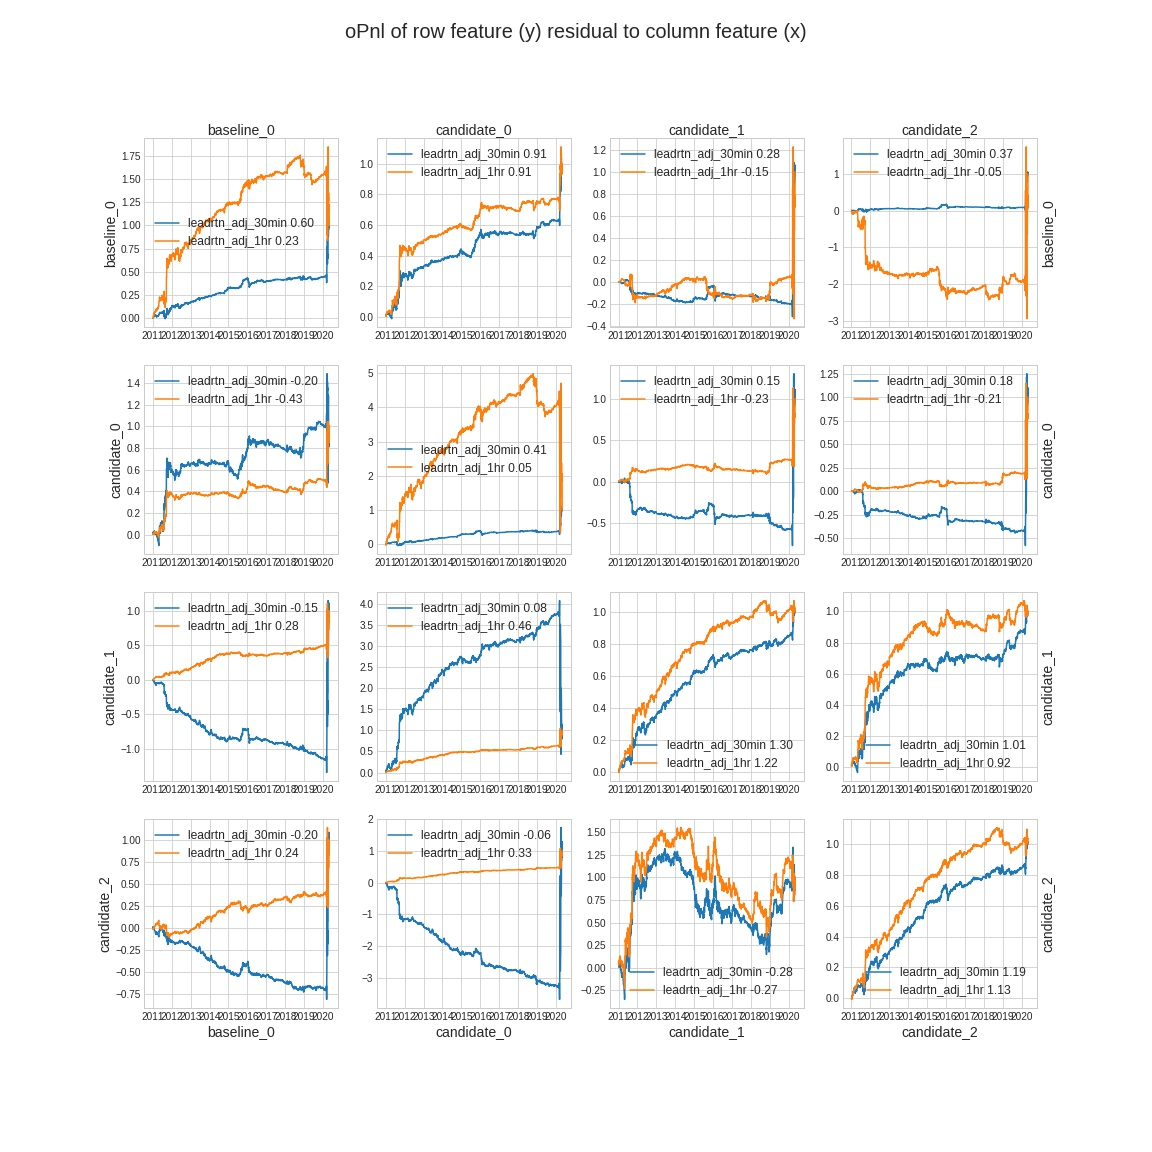

In [12]:
# online learning - baseline 2
#################
%inline

from research.etf_technical import online_runner as reor; reload( reor )
from research.etf_technical import baselines as etfb; reload( etfb )

data = disjoint_returns

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )

# I messed up the checkpoints for this fucker - load from baseline
if False:
    hpso = hps.online.clone(
        start=hps.start,
        end=hps.end,
        targets=['leadrtn_adj_30min'],    
        batch_size=2000,
    )
    runner = reor.OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Expected OnlineRunner_b915b6faa  got ', runner.hash(), h=3, color='teal' )
    dfo = runner()
    disp( hpso )
else:    
    runner = etfb.Baseline.load( 'OnlineRunner_b915b6faa' )
    disp( runner.hps )
    
for profile in runner.output_meta:
    main_fig = profile['main_fig']
    exp_fig = profile['exp_fig']
    reg_fig = profile['reg_fig'] 
    reg_df = profile['regressions']
    if not reg_df.empty:
        reg_df = reg_df.set_index( ['returns', 'lag'] )
    disp( profile['feature'], profile['transform'], h=3, hr=True )
    # disp( pd.DataFrame( profile, index=['value'] ) )
    disp( 'Regressions', reg_df, h=4 )
    disp( reg_fig  )
    disp( exp_fig )
    
# do a baseline against itself ...
#######################

result = baseline.compare( 
    data = runner.output_data,
    features= ['leadrtn_adj_30min_hat_xs_winsorize', 'leadrtn_adj_30min_hat_xs_zscore', 'leadrtn_adj_30min_hat_xs_winsorize_xs_zscore'],
    baseline_forecasts=['leadrtn_adj_30min_hat'],
    weight = 'weight',
    targets = ['leadrtn_adj_30min', 'leadrtn_adj_1hr'],
    start = '20110101',
    end = None,
)

disp( f'Self baselining {baseline.__name__} ', h=2 )
disp( 'Baseline forecast map', result['baseline_features'],  h=2)
disp( 'Candidate forecast map', result['candidate_features'],  h=2)
disp( 'Forecast correlations', result['fcst_corrs'],  h=2)
disp( 'Orthog SRs', result['osrs'],  h=2)
disp( 'Orthog Pnl', result['opnls'],  h=2)    
    

# with disjoint returns
------



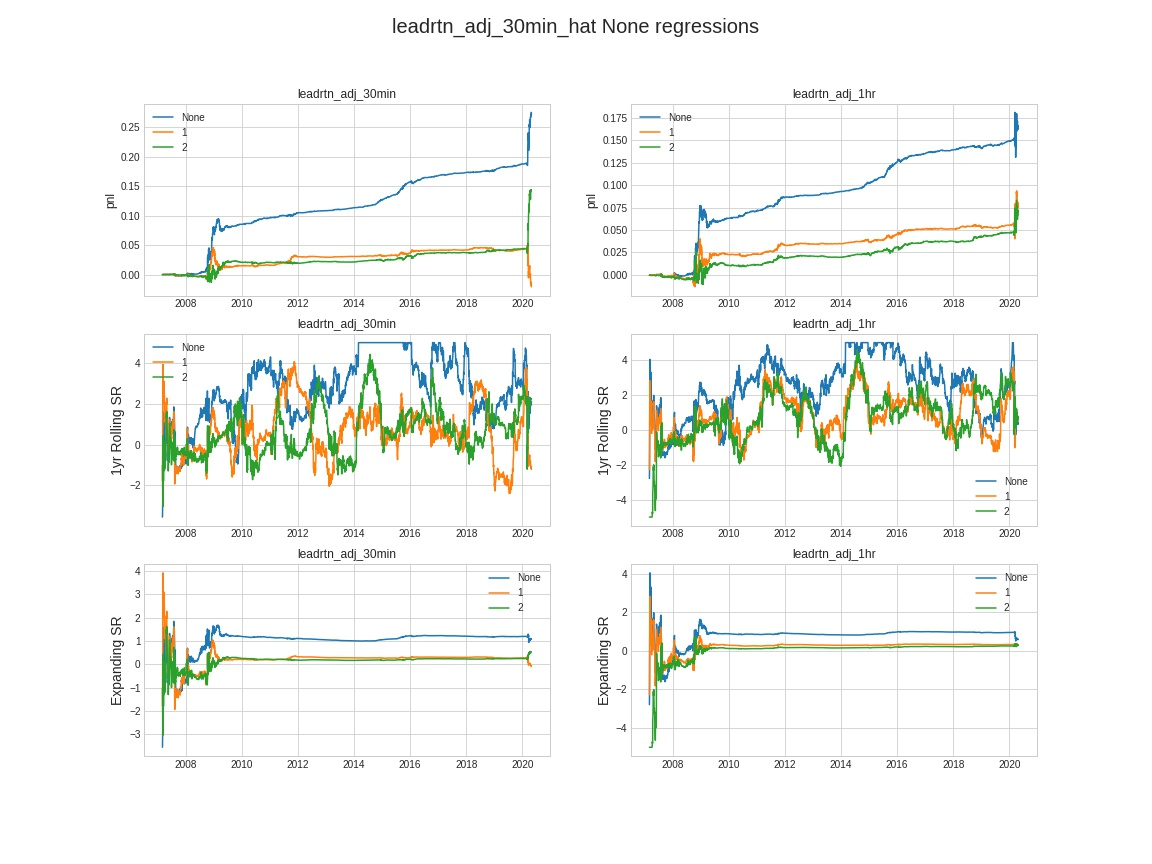

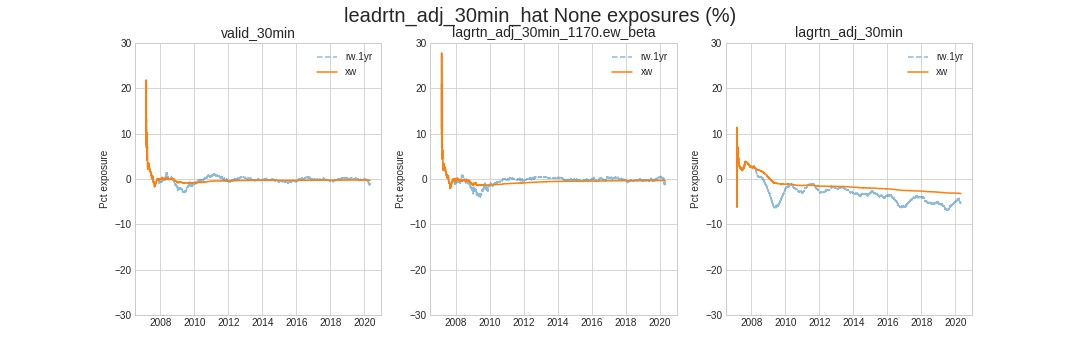

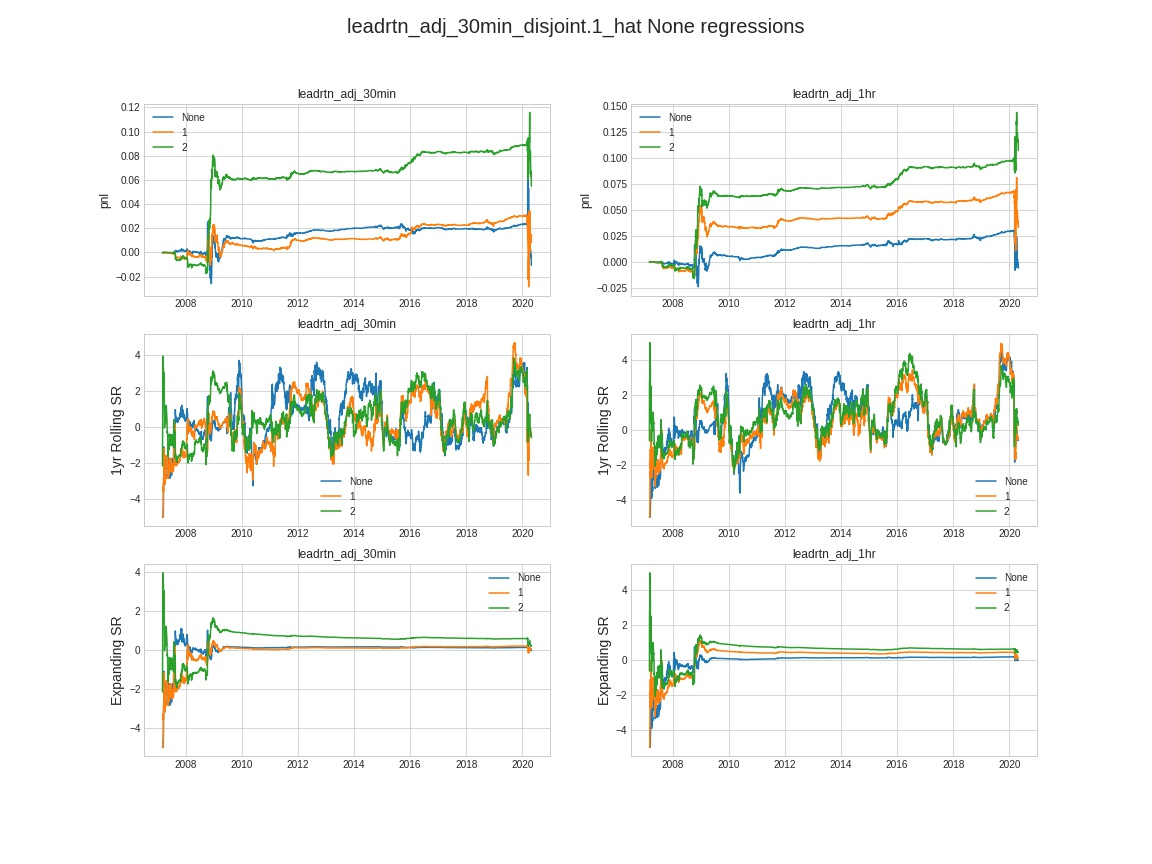

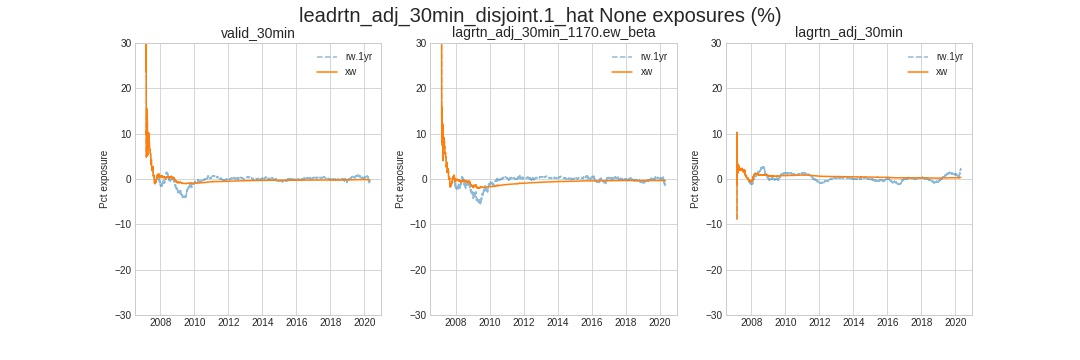

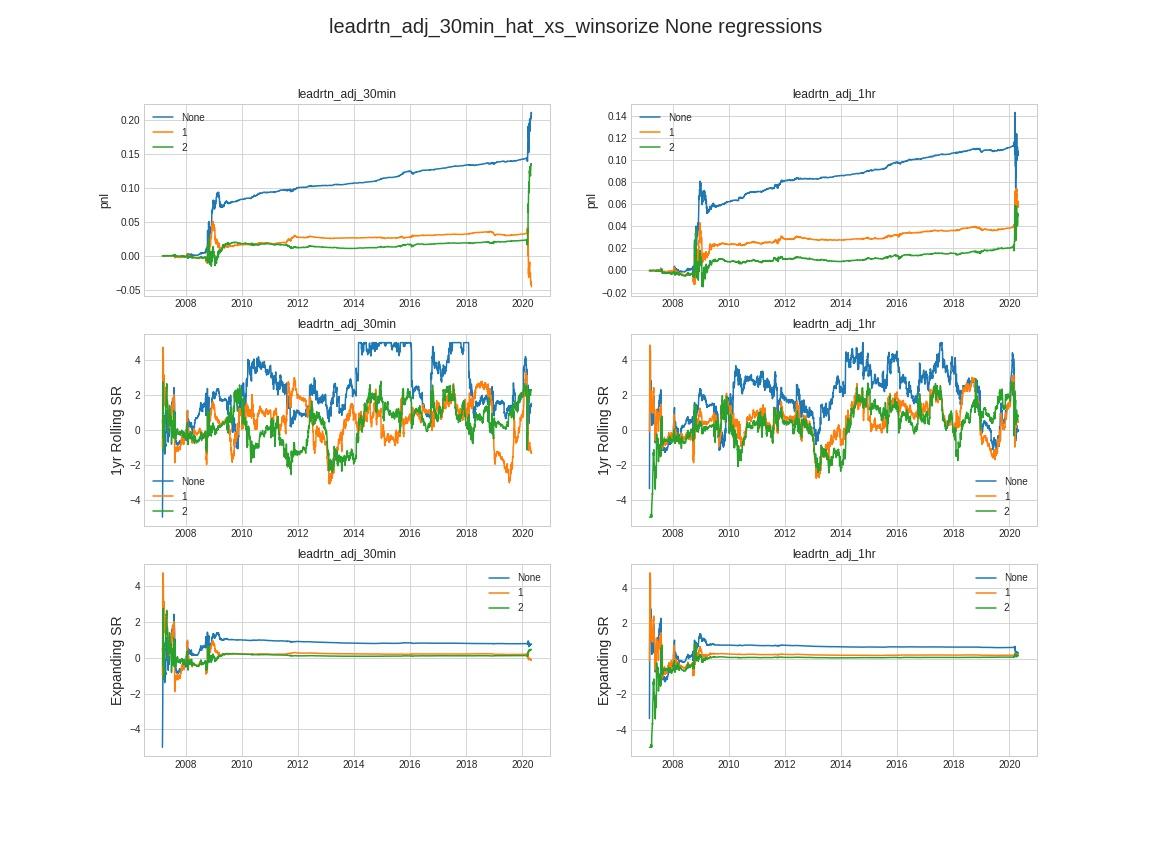

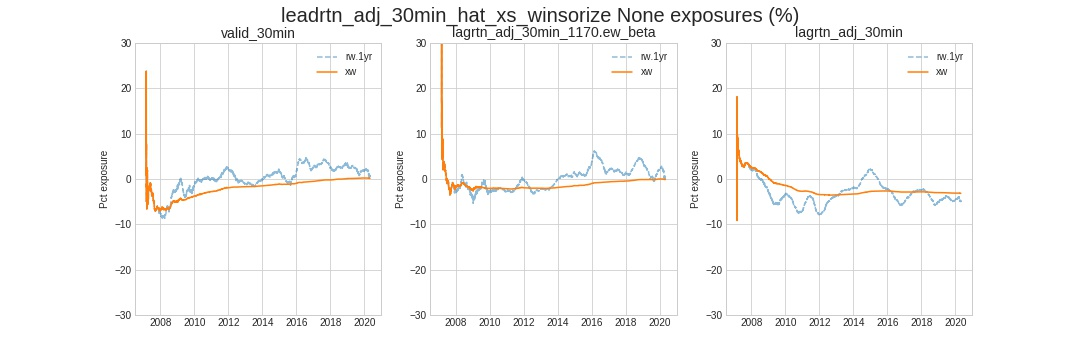

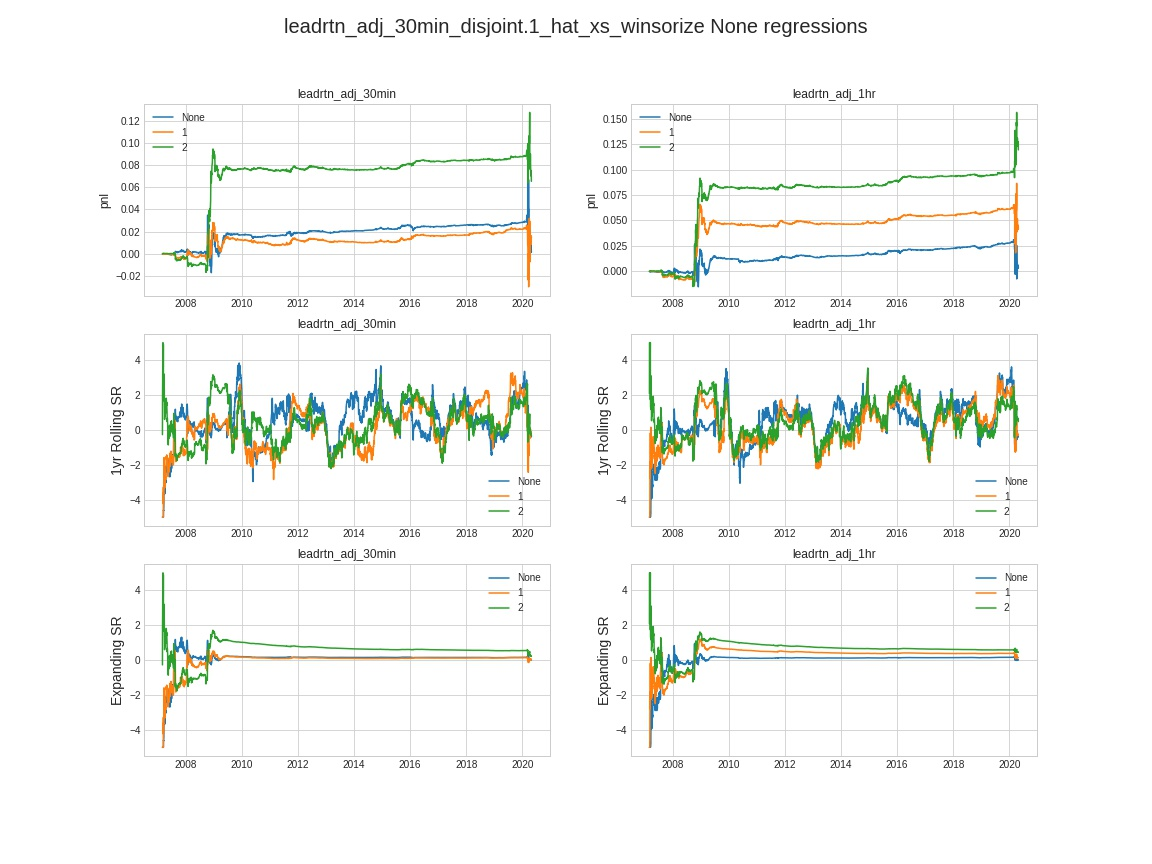

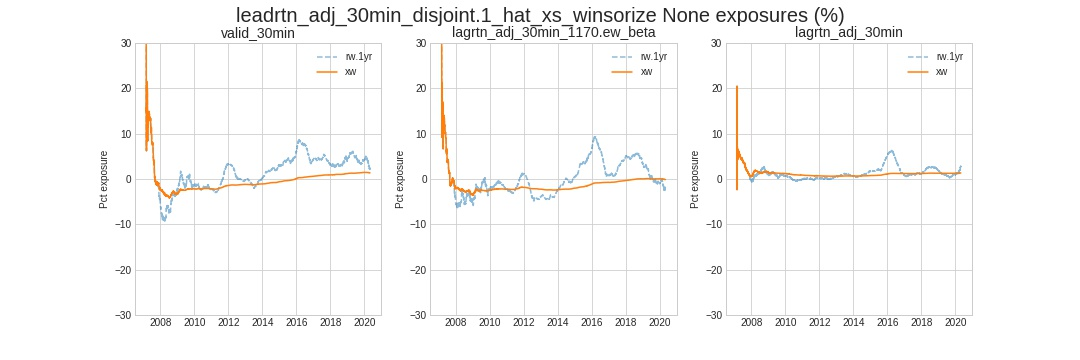

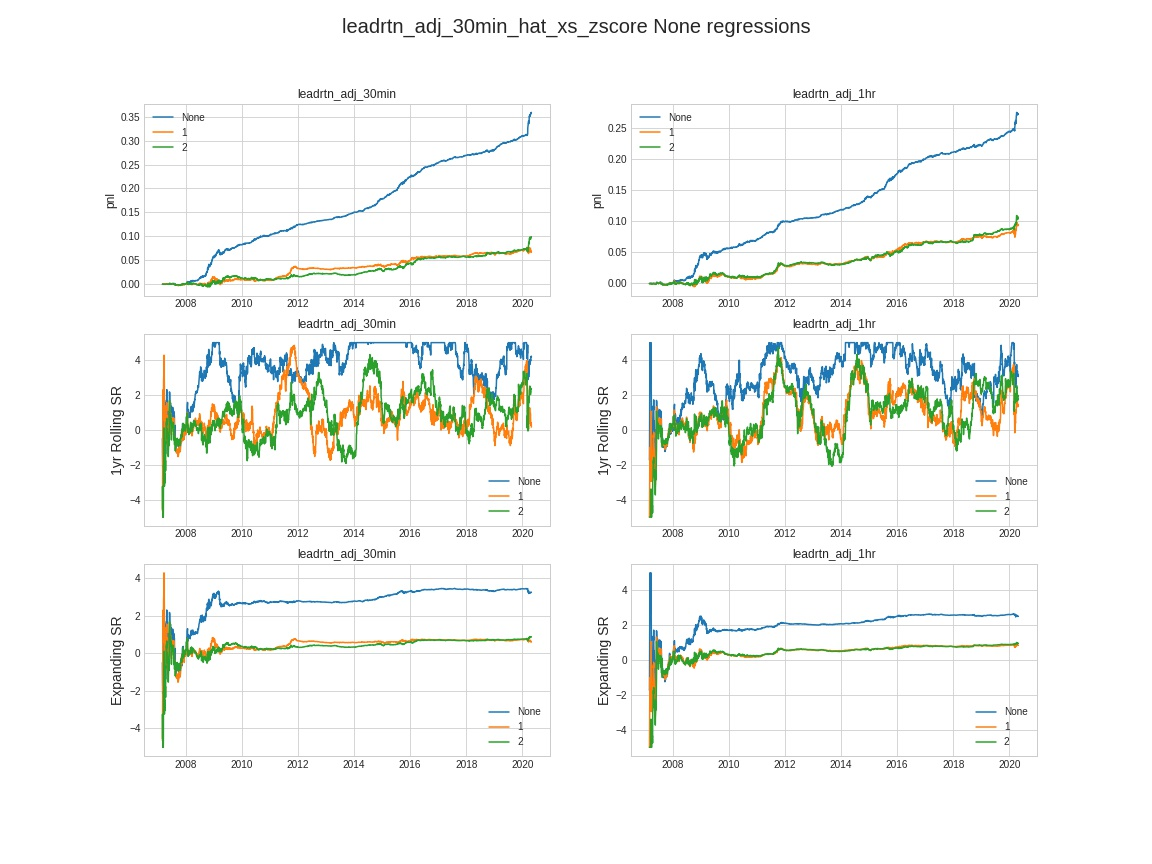

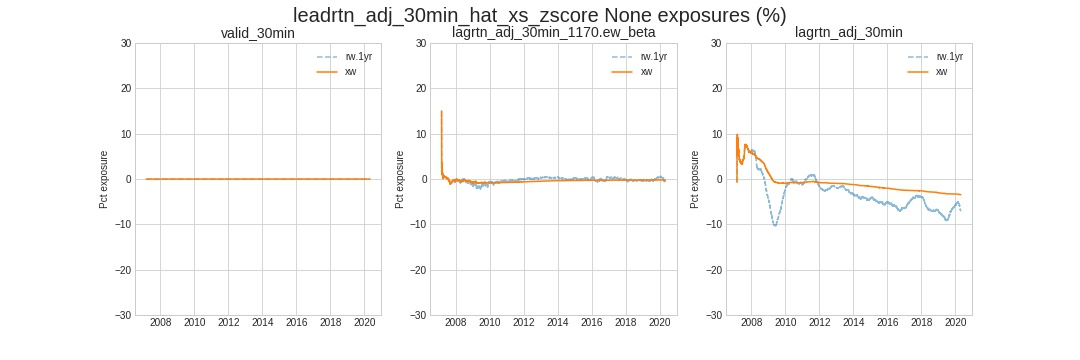

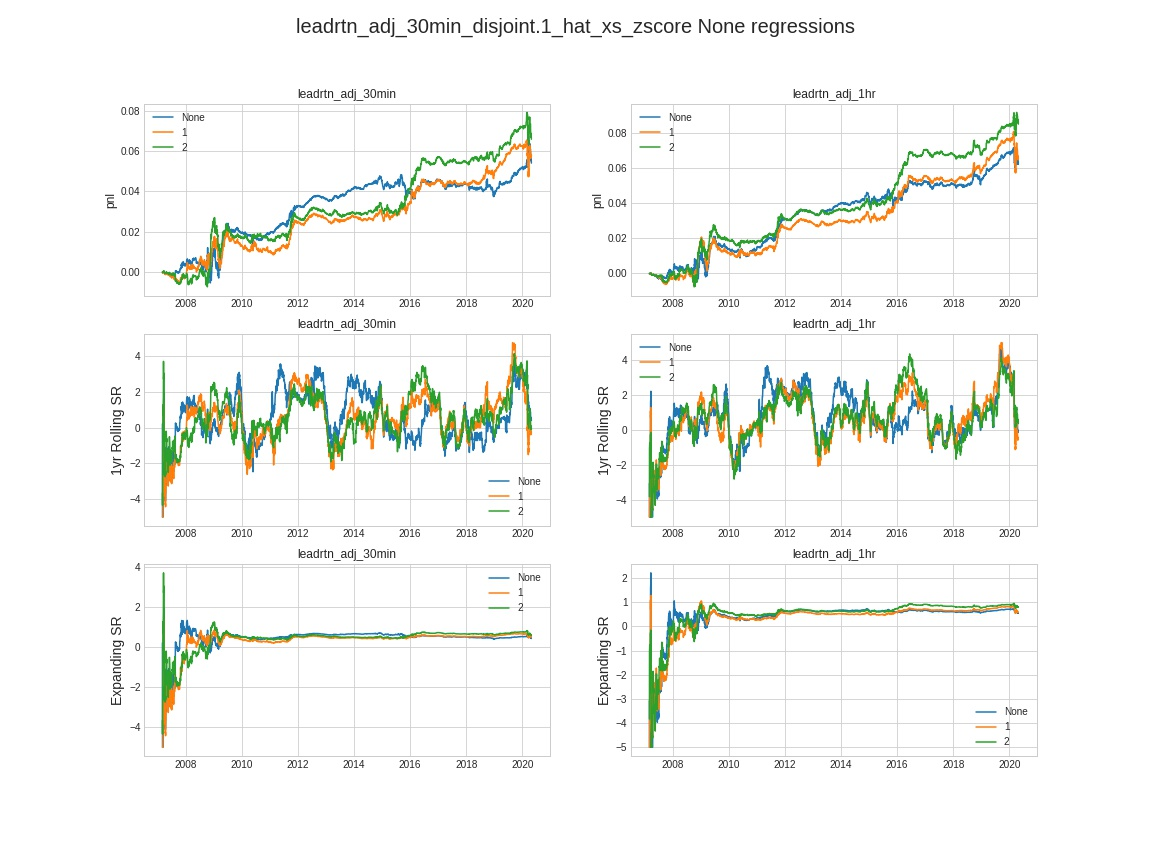

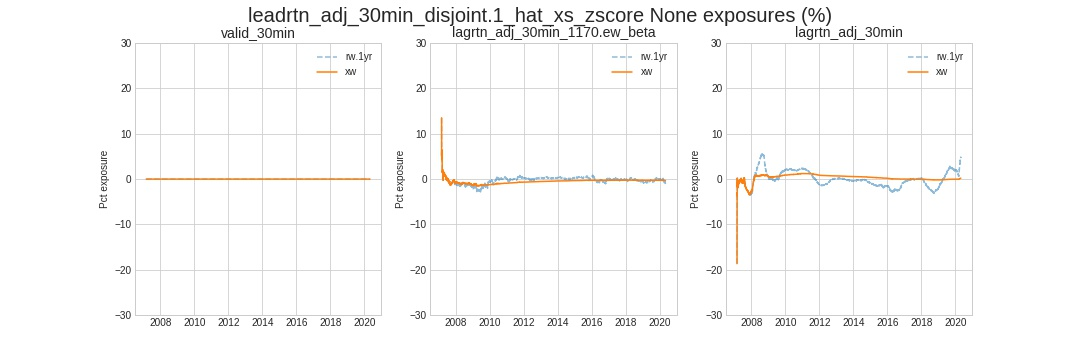

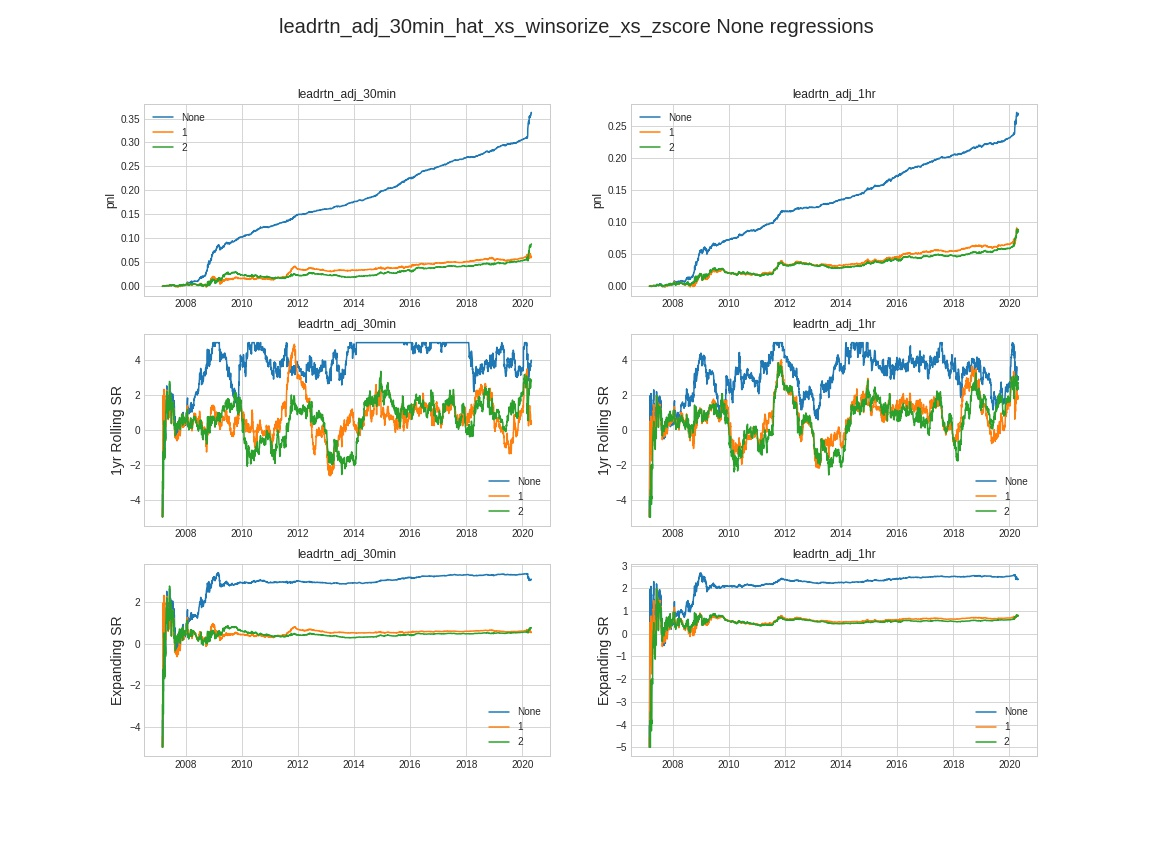

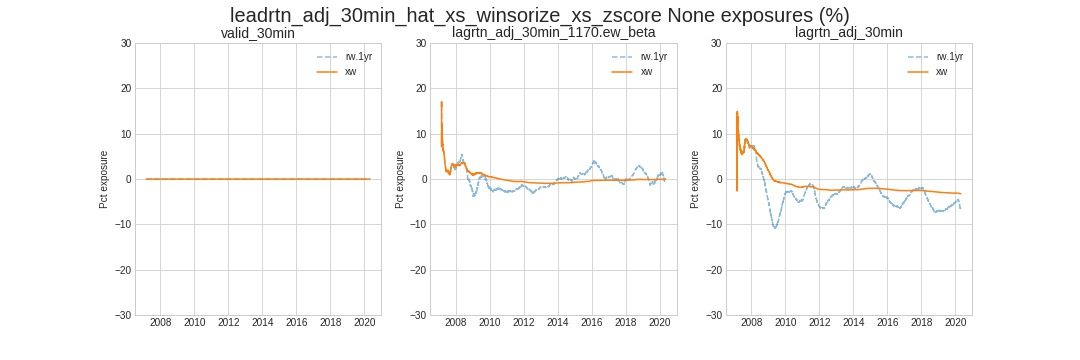

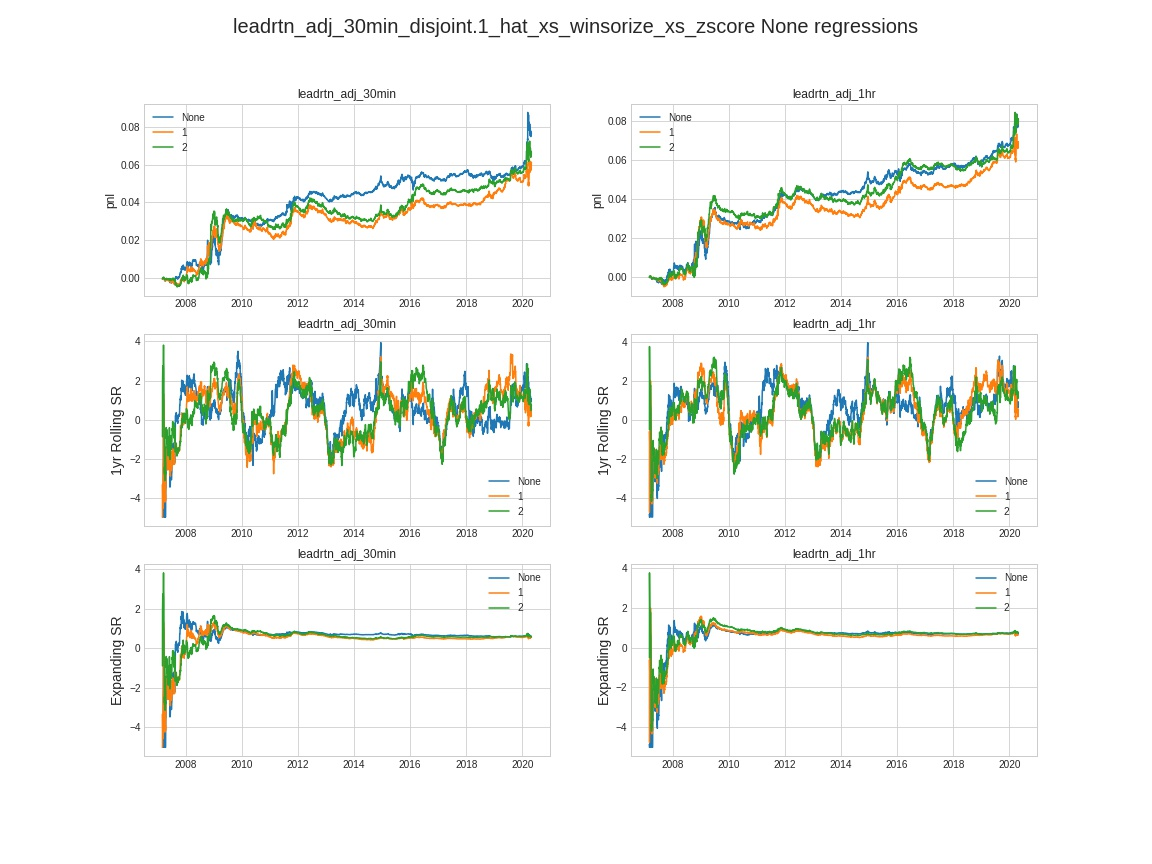

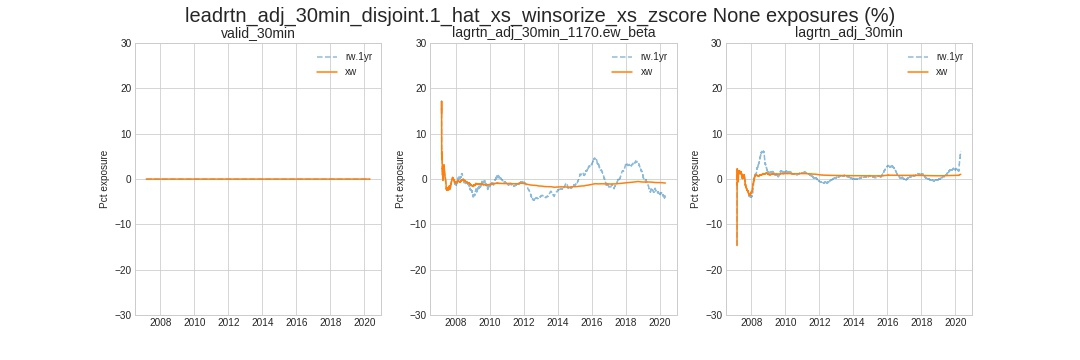

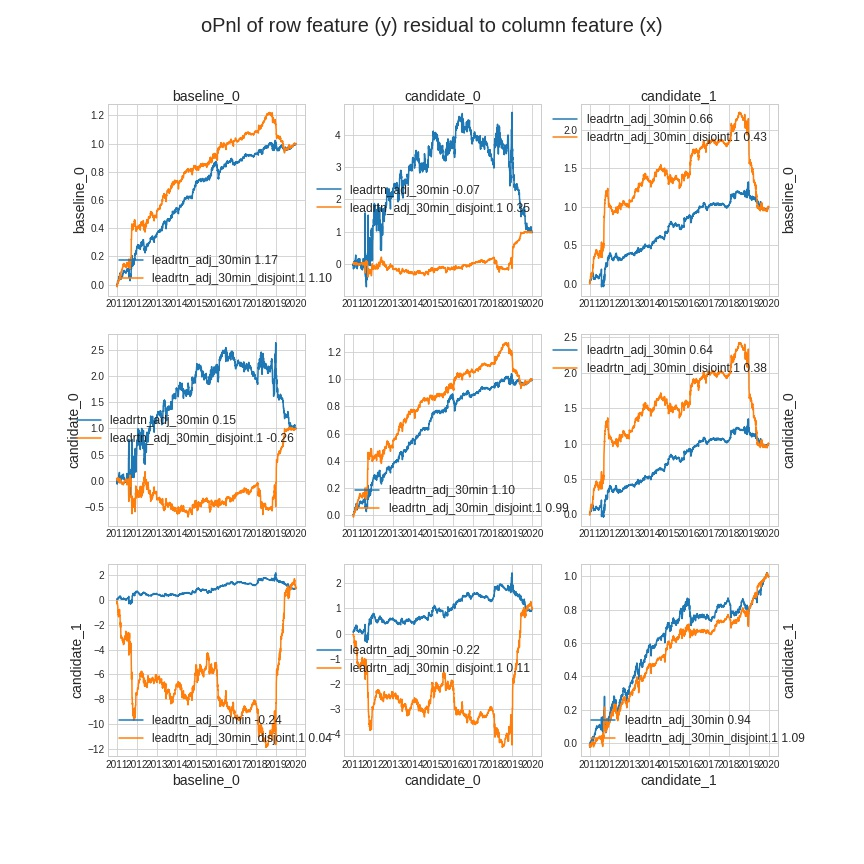

In [7]:
# online learning - disjoint
#################
%inline

from research.etf_technical import online_runner as reor; reload( reor )
from research.etf_technical import baselines as etfb; reload( etfb )


data = disjoint_returns

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )

hpso = hps.online.clone(
    start=hps.start,
    end=hps.end,
    targets=['leadrtn_adj_30min', 'leadrtn_adj_30min_disjoint.1'],    
    batch_size=2000,
)
runner = reor.OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
runner.data = data
disp( f'Expected OnlineRunner_ade2475c3  got ', runner.hash(), h=3, color='teal' )
dfo = runner()

# save this fucker as a baseline
try:
    etfb.Baseline.make( runner, hps=hpso, notebook=mx.Config.code, notes='first experiment with disjoint returns', )
except:
    disp( runner.hash(), ' has already been baselined', h=3, color='orange' )

disp( hpso )
for profile in runner.output_meta:
    main_fig = profile['main_fig']
    exp_fig = profile['exp_fig']
    reg_fig = profile['reg_fig'] 
    reg_df = profile['regressions']
    if not reg_df.empty:
        reg_df = reg_df.set_index( ['returns', 'lag'] )
    disp( profile['feature'], profile['transform'], h=3, hr=True )
    # disp( pd.DataFrame( profile, index=['value'] ) )
    disp( 'Regressions', reg_df, h=4 )
    disp( reg_fig  )
    disp( exp_fig )

# compare against an older baselines
######

baseline = etfb.Baseline.load( 'OnlineRunner_b915b6faa' )
result = baseline.compare( 
    data = runner(),
    features= ['leadrtn_adj_30min_hat_xs_winsorize_xs_zscore', 'leadrtn_adj_30min_disjoint.1_hat_xs_winsorize_xs_zscore'],
    weight = 'weight',
    targets = ['leadrtn_adj_30min', 'leadrtn_adj_30min_disjoint.1'],
    start = '20110101',
    end = '20200101',
    baseline_forecasts=['leadrtn_adj_30min_hat_xs_winsorize_xs_zscore'],
)

disp( f'Comparing {runner.hash()} against baseline {baseline.__name__} ', h=2 )
disp( 'Baseline forecast map', result['baseline_features'],  h=2)
disp( 'Candidate forecast map', result['candidate_features'],  h=2)
disp( 'Forecast correlations', result['fcst_corrs'],  h=2)
disp( 'Orthog SRs', result['osrs'],  h=2)
disp( 'Orthog Pnl', result['opnls'],  h=2)
